# LAB-4 

### *Amazon Alexa Reviews Analysis using Logistic Regression*

### The aim is to analyse Alexa's reviews by NLP. If the feedback is positive, the result is 1, else it is 0. 

### Importing Libraries

In [1]:
import pandas as pd
import nltk 
nltk.download('stopwords')                 # download the stopwords from NLTK

import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

from sklearn.linear_model import LogisticRegression  
from sklearn.feature_extraction.text import CountVectorizer 
import imblearn                            # libraries for random sampling
from collections import Counter
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt            # library for visualization
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Getting our Data

In [2]:
df = pd.read_csv(r'../Dataset/amazon_alexa.csv')
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


### Data Preprocessing

In [3]:
df = df.drop(['rating', 'date', 'variation'], axis = 1)
df

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1
...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1
3146,"Listening to music, searching locations, check...",1
3147,"I do love these things, i have them running my...",1
3148,Only complaint I have is that the sound qualit...,1


In [4]:
df.isnull().any()  # checking for null values

verified_reviews    False
feedback            False
dtype: bool

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   verified_reviews  3150 non-null   object
 1   feedback          3150 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.3+ KB


In [6]:
def process_rev(rev):
    """Process review function.
    Input:
        rev: a string containing a review
    Output:
        rev_clean: a list of words containing the processed review

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # tokenize reviews
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    rev_tokens = tokenizer.tokenize(rev)

    rev_clean = []
    for word in rev_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # rev_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            rev_clean.append(stem_word)

    return rev_clean

In [7]:
# using the process_rev function for:
# 1. Removing stop words
# 2. Tokenization
# 3. Stemming
A = []
a = df['verified_reviews']
for i in a:
  i = process_rev(i)
  A.append(i)
df['verified_reviews'] = A
df

,verified_reviews,feedback
0,"[love, echo]",1
1,[love],1
2,"[sometim, play, game, answer, question, correc...",1
3,"[lot, fun, thing, 4, yr, old, learn, dinosaur,...",1
4,[music],1
...,...,...
3145,"[perfect, kid, adult, everyon]",1
3146,"[listen, music, search, locat, check, time, lo...",1
3147,"[love, thing, run, entir, home, tv, light, the...",1
3148,"[complaint, sound, qualiti, great, mostli, use...",1


### Vectorizing

In [8]:
cv = CountVectorizer(max_features=1500, analyzer='word', lowercase=False) 

In [9]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: " ".join(x) )  # to join all words in the lists
X = cv.fit_transform(df['verified_reviews'])  # predictor variable 'X'

In [10]:
df

,verified_reviews,feedback
0,love echo,1
1,love,1
2,sometim play game answer question correctli al...,1
3,lot fun thing 4 yr old learn dinosaur control ...,1
4,music,1
...,...,...
3145,perfect kid adult everyon,1
3146,listen music search locat check time look weat...,1
3147,love thing run entir home tv light thermostat ...,1
3148,complaint sound qualiti great mostli use comma...,1


In [11]:
y = pd.DataFrame(df['feedback'])  # respose variable 'y'
y.head()

,feedback
0,1
1,1
2,1
3,1
4,1


### Splitting for Training and Testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)  # splitting in the ratio 90:10

### Model

In [13]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(random_state=0)

### Making Predictions

In [14]:
y_pred = classifier.predict(X_test)
y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Checking Accuracy

In [15]:
roc_auc_score(y_test, y_pred)

0.6871173808890072

In [16]:
classifier.score(X_test, y_test)

0.9396825396825397

# Predictions are 93.96% accurate.

### Results' Visualization

In [17]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 10,  16],
       [  3, 286]], dtype=int64)

Text(0.5, 1.0, 'Accuracy Score: 0.6871173808890072')

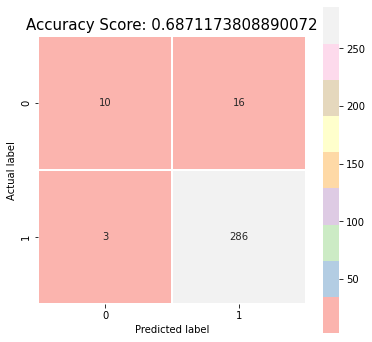

In [18]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square = True, cmap = 'Pastel1')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(roc_auc_score(y_test, y_pred))
plt.title(all_sample_title, size = 15)